Table 0 column names: ['Gasoline', '', '557,605', '', '726,057', '', '796,667'], external: False
Table 1 column names: ['Crude oil', '', '351,707', '', '429,038', '', '517,183'], external: False
Table 2 column names: ['Basic organic chemicals', '', '133,046', '', '198,453', '', '223,679'], external: False
Table 3 column names: ['Kerosene', '', '72,385', '', '112,519', '', '168,017'], external: False
Table 4 column names: ['Synthetic fiber monomers and polymers', '', '42,388', '', '45,464', '', '45,335'], external: False
Table 5 column names: ['', '', '2,048,654', '', '2,679,500', '', '3,257,356'], external: False
Table 6 column names: ['Sale of materials and others', '', '54,986', '', '59,990', '', '59,590'], external: False
Table 7 column names: ['', '', '56,070', '', '61,384', '', '60,812'], external: False


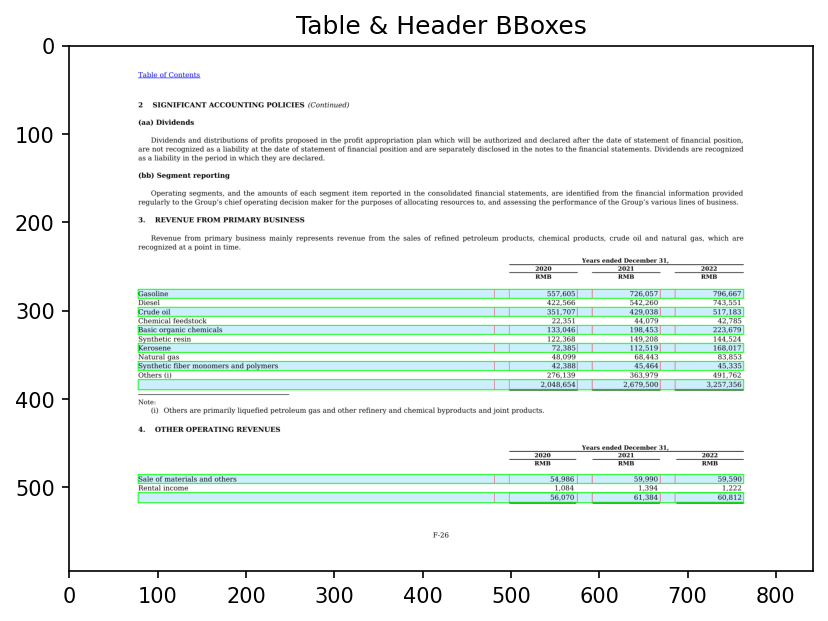

In [20]:
import fitz
import numpy as np
import matplotlib.pyplot as plt


def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))


pdf_path = "pdf_sample/000d93bd-8f91-30cf-97ab-e612ba04b3f5.pdf"
doc = fitz.open(pdf_path)

page = doc[218]
tabs = page.find_tables()

for i, tab in enumerate(tabs):
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor["red"], width=0.3)
    page.draw_rect(tab.bbox, color=fitz.pdfcolor["green"])
    print(
        f"Table {i} column names: {tab.header.names}, external: {tab.header.external}"
    )

show_image(page, f"Table & Header BBoxes")

In [21]:
import json
import os
from openai import OpenAI
import re

pdf_name = os.path.basename(pdf_path).split(".")[0]

with open("final_results.json", "r") as f:
    data = json.load(f)

llm = OpenAI(
    api_key="sk-436808c023b34f4185c96d8d438aa4a3", base_url="https://api.deepseek.com"
)

tables = data[pdf_name]["tables"]

all_tables_text = ""
for page_num, text in tables.items():
    all_tables_text += text + f"\n{'-'*80}\n"

segment_prompt = "You are a finance expert. You are given a revenue table in a text format extracted from an annual report. Your task is to return the segments that form the revenue and the corresponding values. Please extract the information from only one table, without combining the results of all the tables. You must output all the segments in a json format: {'segment_name': {'year 1': value, 'year 2': 'value'}}. No need to output other information."


def convert_json(text: str) -> dict:
    # Use regular expression to extract the JSON string inside the Markdown code block
    json_match = re.search(r"```json\n(.*?)\n```", text, re.DOTALL)
    if not json_match:
        return {}

    json_str = json_match.group(1)

    # Load the JSON string into a dictionary
    try:
        data = json.loads(json_str)
    except json.JSONDecodeError as e:
        return {}

    return data


def extract_segments():
    response = llm.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": segment_prompt},
            {"role": "user", "content": all_tables_text},
        ],
        temperature=0,
        stream=False,
    )

    output = response.choices[0].message.content

    segments = convert_json(output)
    segments = segments

    return segments


segments = extract_segments()

segments

{'Gasoline': {'2020': 557605, '2021': 726057, '2022': 796667},
 'Diesel': {'2020': 422566, '2021': 542260, '2022': 743551},
 'Crude oil': {'2020': 351707, '2021': 429038, '2022': 517183},
 'Chemical feedstock': {'2020': 22351, '2021': 44079, '2022': 42785},
 'Basic organic chemicals': {'2020': 133046, '2021': 198453, '2022': 223679},
 'Synthetic resin': {'2020': 122368, '2021': 149208, '2022': 144524},
 'Kerosene': {'2020': 72385, '2021': 112519, '2022': 168017},
 'Natural gas': {'2020': 48099, '2021': 68443, '2022': 83853},
 'Synthetic fiber monomers and polymers': {'2020': 42388,
  '2021': 45464,
  '2022': 45335},
 'Others (i)': {'2020': 276139, '2021': 363979, '2022': 491762}}

In [26]:
segments_dict = {}
for tab in tabs:
    info = tab.extract()[0]
    info = list(filter(lambda x: x != "", info))
    segments_dict[info[0]] = list(map(lambda x: int(x.replace(",", "")), info[1:]))

segments_dict

{'Gasoline': [557605, 726057, 796667],
 'Crude oil': [351707, 429038, 517183],
 'Basic organic chemicals': [133046, 198453, 223679],
 'Kerosene': [72385, 112519, 168017],
 'Synthetic fiber monomers and polymers': [42388, 45464, 45335],
 '2,048,654': [2679500, 3257356],
 'Sale of materials and others': [54986, 59990, 59590],
 '56,070': [61384, 60812]}